In [12]:
import numpy as np
from music21 import midi, note, stream, instrument, meter, key, tempo, chord
from music21 import duration as dur
from music21.note import Rest
import matplotlib.pyplot as plt
import random


In [2]:
def play(score):
    # shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

# Part 1.2 - Transitioning to the Bolero
We add notes using the metrical structure (will be used to progressively replace the brownian noise from the exposition)


In [35]:
# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open("Bolero-Ravel_Flute_Bat_Strings.mid")
mf.read()
mf.close()
s = stream.Stream()
s.append(midi.translate.midiFileToStream(mf))


We use the metrical structure as a guide to add notes with a certain probability. We then augment these probabilities as we are adding more and more of the melodic elements to the music to create a sense of convergence onto the Bolero.

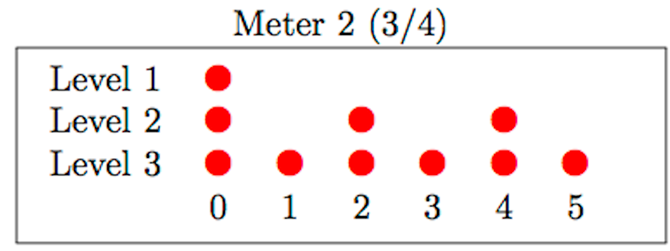

image source :
An Attentional Effect of Musical Metrical Structure
Katz J, Chemla E, Pallier C (2015) An Attentional Effect of Musical Metrical Structure. PLOS ONE 10(11): e0140895. https://doi.org/10.1371/journal.pone.0140895 

We consider the number of times a note appears in the above metrical structure as its relative probability

In [9]:
def intro_metrical_structure(s):
    """
    Introduces the melodic theme (here of the Bolero) by gradually adding notes following the metrical structure
    :param s: 
    :return: the new stream created
    """
    # stream to accumulate the midi parts
    new_stream = stream.Stream()

    # time sig and tempo
    ts = meter.TimeSignature('3/4')
    new_stream.append(tempo.MetronomeMark(number = 72))
    new_stream.insert(0, ts)

    # an instrument to play our score
    new_stream.insert(0, instrument.Guitar())

    # probabilities for each of the beats of the measure to be added (metrical structure)
    initial_probabilities = np.array([3, 1, 2, 1, 2, 1], dtype = 'float32') / 10


    # looping over the different parts of the score
    for parts in s:
        for part in parts:

            # accumulator for the duration of the notes encountered 
            duration = 0

            # creating a part with the right Time signature
            new_part = stream.Part()
            new_part.insert(0, ts)

            # reseting the probabilities for each part
            probabilities = initial_probabilities

            # on each note or rest
            for element in part.flat.notesAndRests[0:100]:

                # increasing the probabilities once each two measures to create a sense 
                # of convergence (the melody begins to make sense)
                elem_duration = element.duration.quarterLength
                if (duration + elem_duration >= 6):
                    probabilities *= 1.3

                # getting the new accumulated duration
                duration = (duration + elem_duration) % 6

                # adding the current note with a particular probability
                # or substituting it by a rest of same duration
                if (random.random() < probabilities[int(duration)] * elem_duration):
                    new_part.append(element)
                else:
                    r = note.Rest()
                    r.duration = element.duration
                    new_part.append(r)

            # inserting the part
            new_stream.insert(0, new_part)
    return new_stream
        

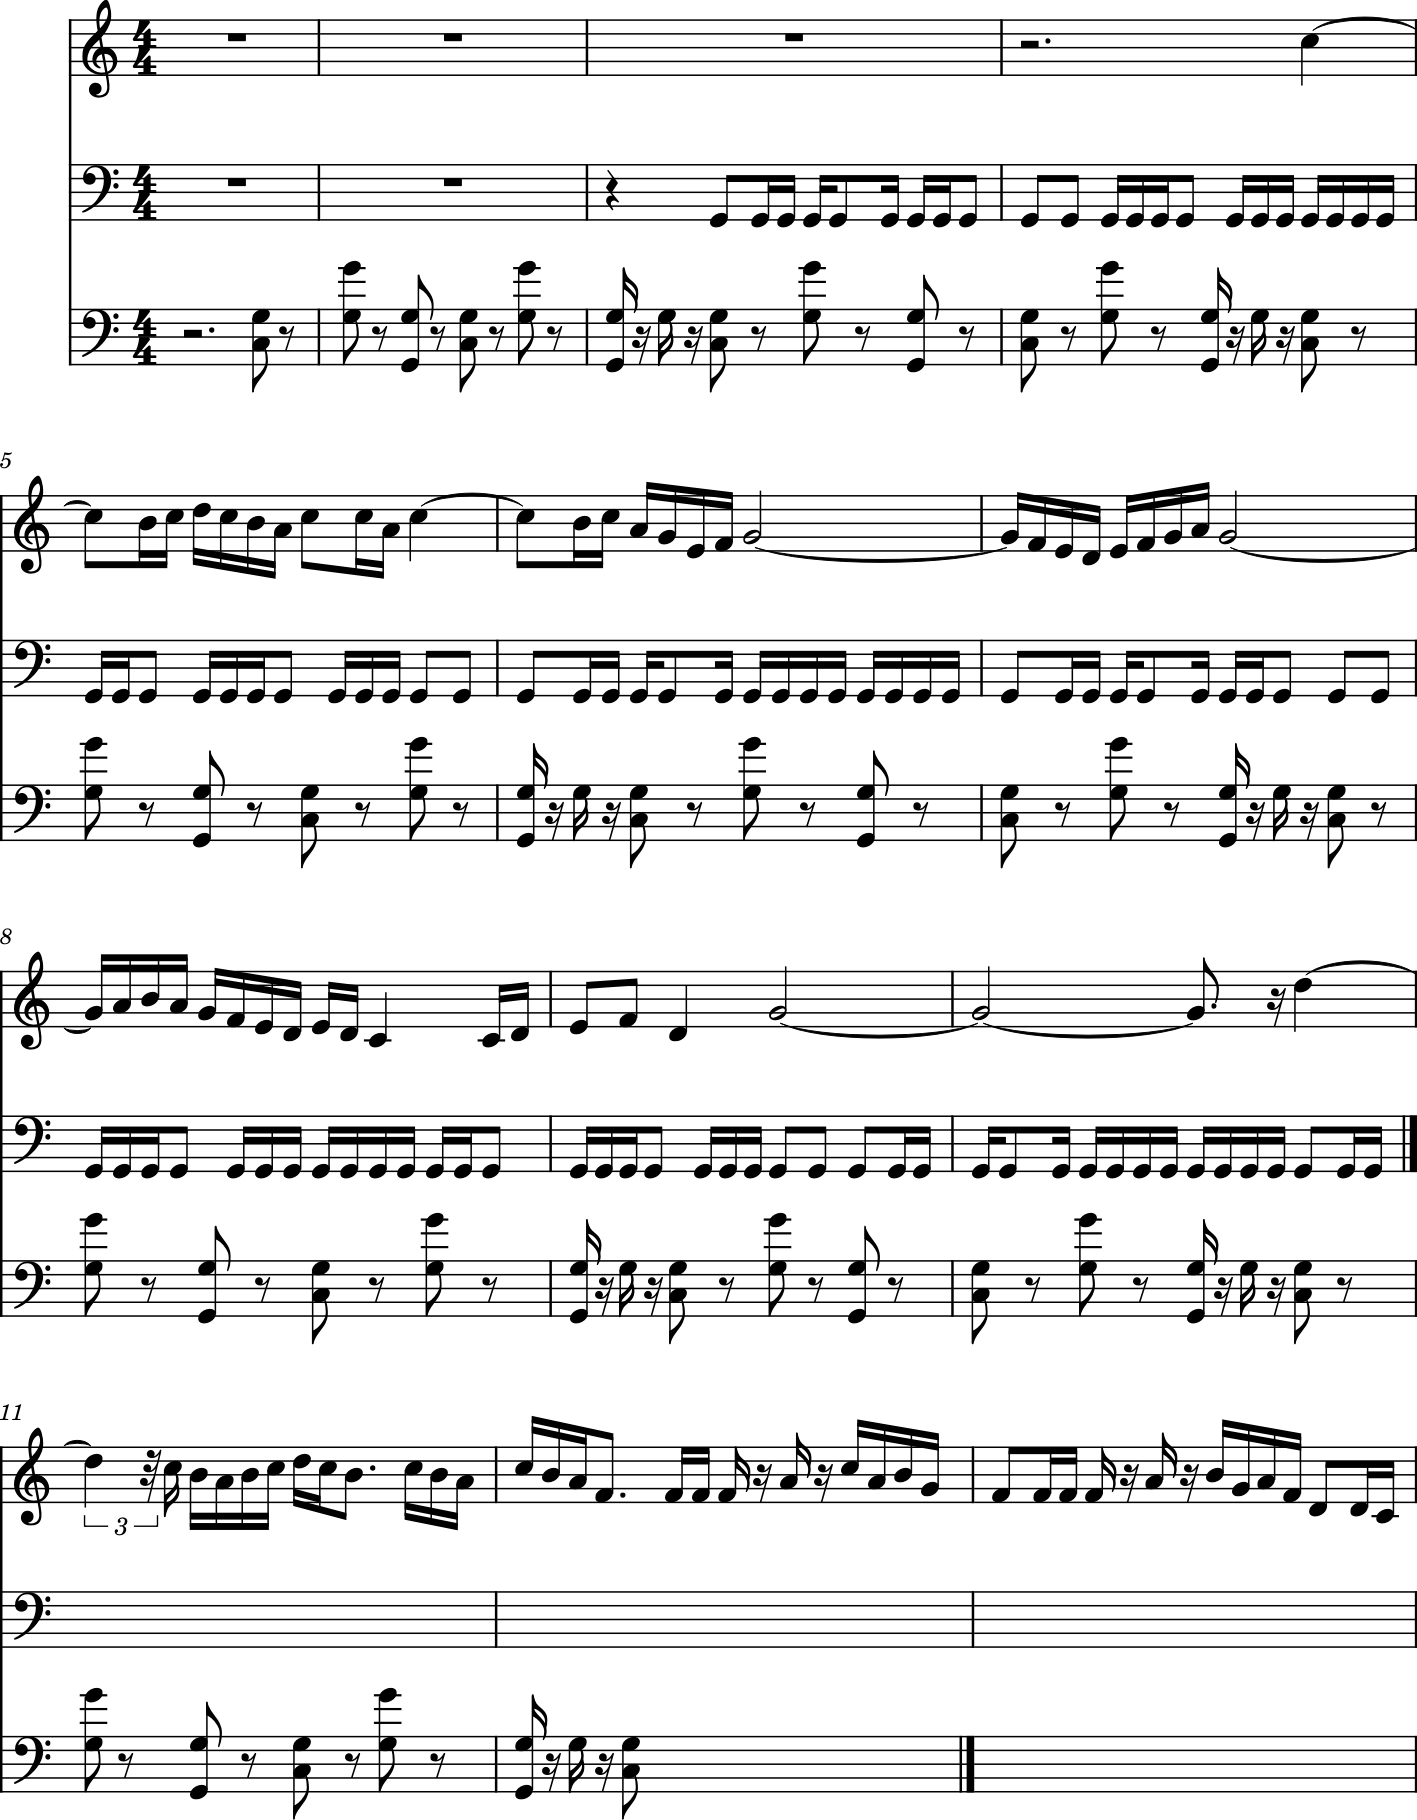

In [39]:
# showing (a part of) the original partition before using the intro_metrical_structures (to compare)
original = stream.Stream()
def show_original(s):
    for parts in s:
        for part in parts:
            new_part = stream.Part()
            for element in part.flat.notesAndRests[0:100]:
                new_part.append(element)
            original.insert(0, new_part)
    original.show()
show_original(s)

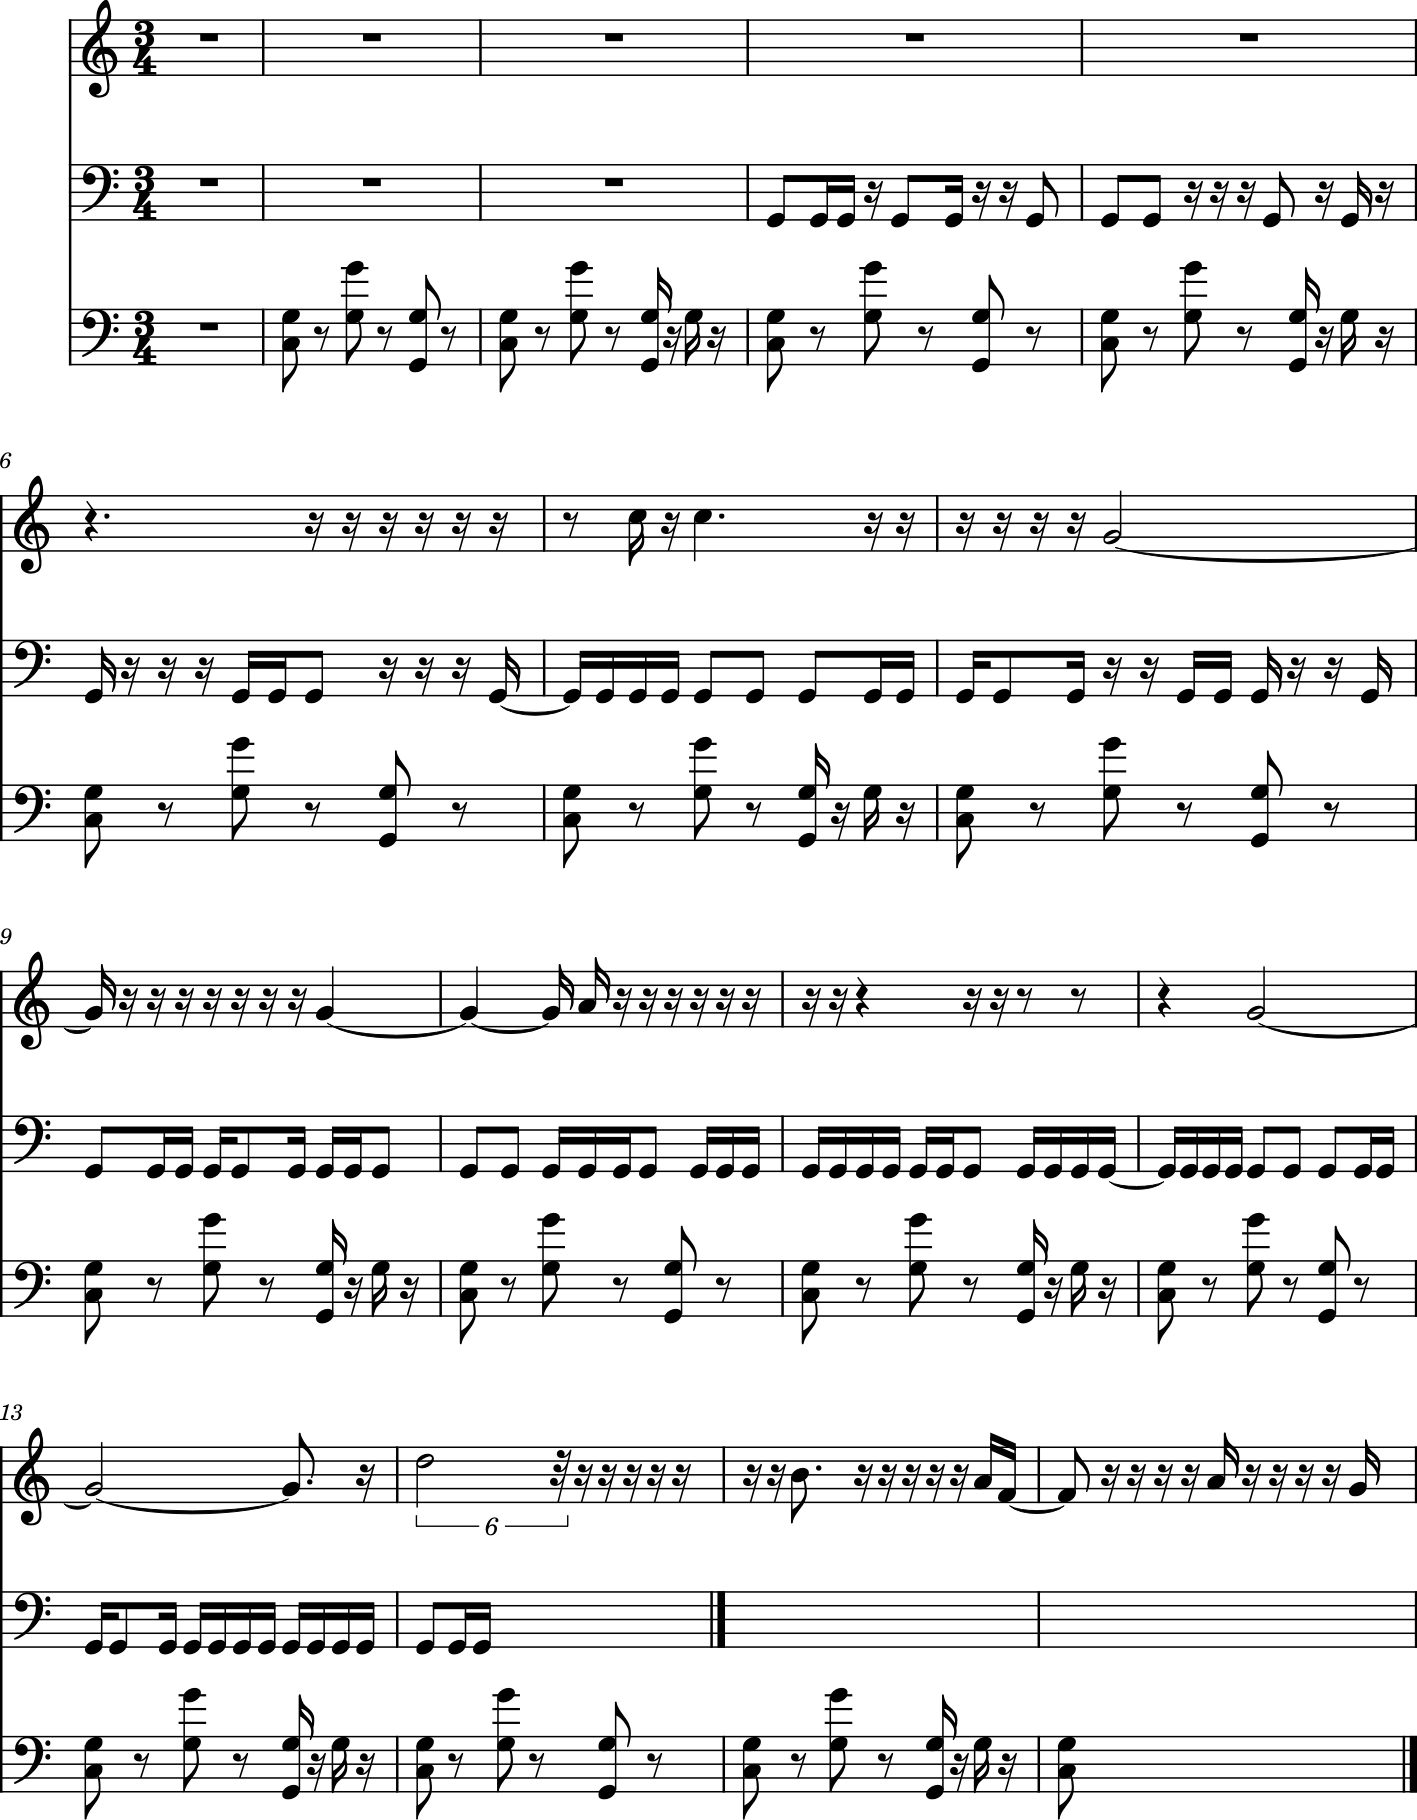

In [40]:
# the new partition in which we gradually add more and more notes from the original partition
new_stream = intro_metrical_structure(s)
new_stream.show()

In [6]:
play(new_stream)

# Part 2 - Disruptive Element

### Brownian Motion
The introduction of chaotic elements is in parts done using brownian motion (the reasons for which are detailed below), the next cells create the framework with which we work with Brownian motion : some constants relative to our outputs and a method to simulate Brownian motion.

In [13]:
# simulating brownian motion from t=0 to t=TIME_HORIZON
TIME_HORIZON = 700.0
# number of sample points for the simulation
TIMESTEPS = 1000

In [14]:
def brownian_motion(dimensions=1, start_value = 0, time_horizon = TIME_HORIZON, timesteps = TIMESTEPS):
    """
    method to simulate brownian motion
    :param dimensions: number of dimensions in which we simulate
    :param start_value: value at which the brownian motion starts
    :param time_horizon: time until which we simulate
    :param timesteps: number of sample points with which to simulate
    :return: a tuple of the different time points at which we simulate, the actual brownian 
        motion values at these time points as well as the difference between any 2 points in 
        the brownian motion values (as it is more practical to work with)
    """
    
    # partitioning the space into timesteps number of points
    times = np.linspace(0.0, time_horizon, timesteps)
    step_length = times[1] - times[0]

    # as brownian motion at time t1 - brownian motion at time t0 ~ Normal(mean = 0, variance = t1-t0)
    # scale is the standard deviation, so we take the square root of the step_length
    diff_b = np.random.normal(size = (timesteps-1, dimensions), scale = np.sqrt(step_length)) 

    brownian_motion = np.zeros(shape=(timesteps,dimensions))

    # we start each brownian motion dimension with the given start value
    brownian_motion[0,:] = np.full((1, dimensions), start_value)
    
     # the rest of the values of brownian motion are the cumulative sum of normal values
    brownian_motion[1:,:] = np.cumsum(diff_b, axis = 0) + start_value

    return times, brownian_motion, diff_b

<function matplotlib.pyplot.show(close=None, block=None)>

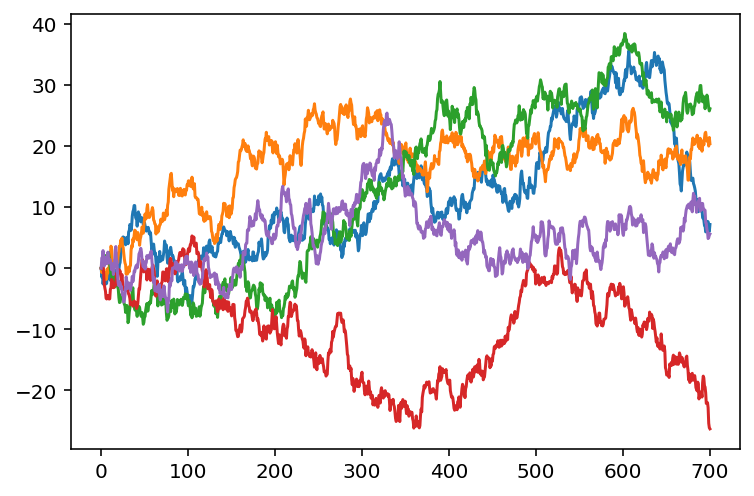

In [34]:
times, brownian_motion_arr, diff_brownian_motion = brownian_motion(dimensions=5)
plt.plot(times, brownian_motion_arr)
plt.show

In [26]:
####
# 2. removing (sporadically) rhythmic values & melodic attributes, restrain range down to dissonance
####

# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open("Bolero-Ravel_Loop.mid")
mf.read()
mf.close()
s1 = stream.Stream()
s1.append(midi.translate.midiFileToStream(mf))


In [27]:
# Note to which we converge : E4
E_PITCH = 64

The below method takes a melody and makes it transition to chaos in 3 ways :

    1. Using brownian motion to sporadically remove rythmic values and slowly turn all notes into half-notes
    2. Restraining the range of notes down to the convergence note, creating dissonances
    3. Repeating it over and over, each time distorting it a little more
    4. Again, using brownian motion: removing notes pseudo-randomly to break down the melody
    
As can be seen, we use brownian motion extensively in this part, as it can act as a random process but still possesses some sense of convergence, one of the examples of which is the fact that brownian motion tends to a parabola when simulating it many times (here, 1000) :

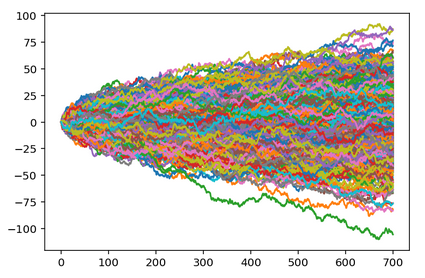

This also formed an interesting link to our theme as brown noise (used in the introduction) is another name for Brownian noise, the both being linked by the fact that they are generated with random intervals. This again underlines the duality of chaos and convergence; we use a process, first to make sound converge to a known melody, just before introducing chaos in several forms using the same process.

As a side note, we tried to use plain random numbers to achieve the above goals but didn't quite get the effect we wanted (it was in a sense "too random"), diverging too fast from the known melody for the listener to feel really distabilised. In other words, if the transition into chaos is too sudden, it is harder to be truly conscious of the power of chaos whereas in a slower transition, the listener still has some grasps onto the known melody, grasps which are removed one after the other until none remain. Moreover, using brownian motion makes the very interesting case for the duality of chaos and convergence explained above.

In [28]:
def transition_to_chaos(s1, convergence_note = E_PITCH):
    """
    Takes a stream and makes it "transition to chaos"
    
    :param s: stream in which to introduce chaotic elements
    :convergence_note: note onto which to slowly converge
    :return: 
    """
    # stream to accumulate the midi parts
    new_stream1 = stream.Stream()

    # time sig and tempo
    ts = meter.TimeSignature('3/4')
    new_stream1.append(tempo.MetronomeMark(number = 72))
    new_stream1.insert(0, ts)

    # an instrument to play our score
    new_stream1.insert(0, instrument.Guitar())


    # getting the arrays of brownian motion (we create one dimension of brownian motion per track in the midi file)
    _,_, diff_brownian_motion = brownian_motion(dimensions = len(mf.tracks))


    # looping over the different parts
    for parts in s1:
        # and getting the corresponding brownian motion array (one per track/part)
        for part, single_brownian_motion in zip(parts, diff_brownian_motion.transpose()):

            # creating a part with the right Time signature
            new_part = stream.Part()
            new_part.insert(0, ts)

            # to shift the array on each iteration
            index = 0

            # looping five times on the same two measures
            for _ in range(5):
                for element in part.flat.notesAndRests:

                    # shifting the array
                    move = single_brownian_motion[index]
                    index += 1

                    # if the brownian motion goes up and the length is smaller than two (the length of a half-note)
                    # we increase the duration of the element so as to slowly remove rythmic values, all notes starting to 
                    # play longer until the length of a half-note
                    elem_duration = element.duration.quarterLength
                    if (elem_duration < 2 and move >= 0):

                        new_elem_duration = round((elem_duration + move) * 4) / 4
                        element.duration = dur.Duration(quarterLength = new_elem_duration)

                    # if the brownian motion is more than -1, we add the element
                    # otherwise it is removed to make the listener lose their balence by violently and 
                    # sporadically simplifying the rythm
                    elif (move >= -1):

                        # if the element is a chord, no new modifications occur, we add it
                        if(element.isClassOrSubclass((chord.Chord,))):
                            c = chord.Chord(element.notes, duration = element.duration)
                            new_part.append(c)
                        else:

                            # if the element is a rest, no new modifications occur, we add it
                            if(element.name == 'rest'):
                                r = note.Rest(duration = element.duration)
                                new_part.append(r)
                            else:

                                # if element is a note, we shift it's pitch towards E4 (convergence note)
                                elem_pitch = element.pitch.midi
                                to_add = 0
                                if (elem_pitch < E_PITCH):
                                    to_add = 1
                                elif (elem_pitch > E_PITCH):
                                    to_add = -1

                                element.pitch.midi = elem_pitch + to_add
                                n = note.Note(duration = element.duration, pitch = element.pitch)
                                new_part.append(n)

            # inserting the part
            new_stream1.insert(0, new_part)
            
    return new_stream1

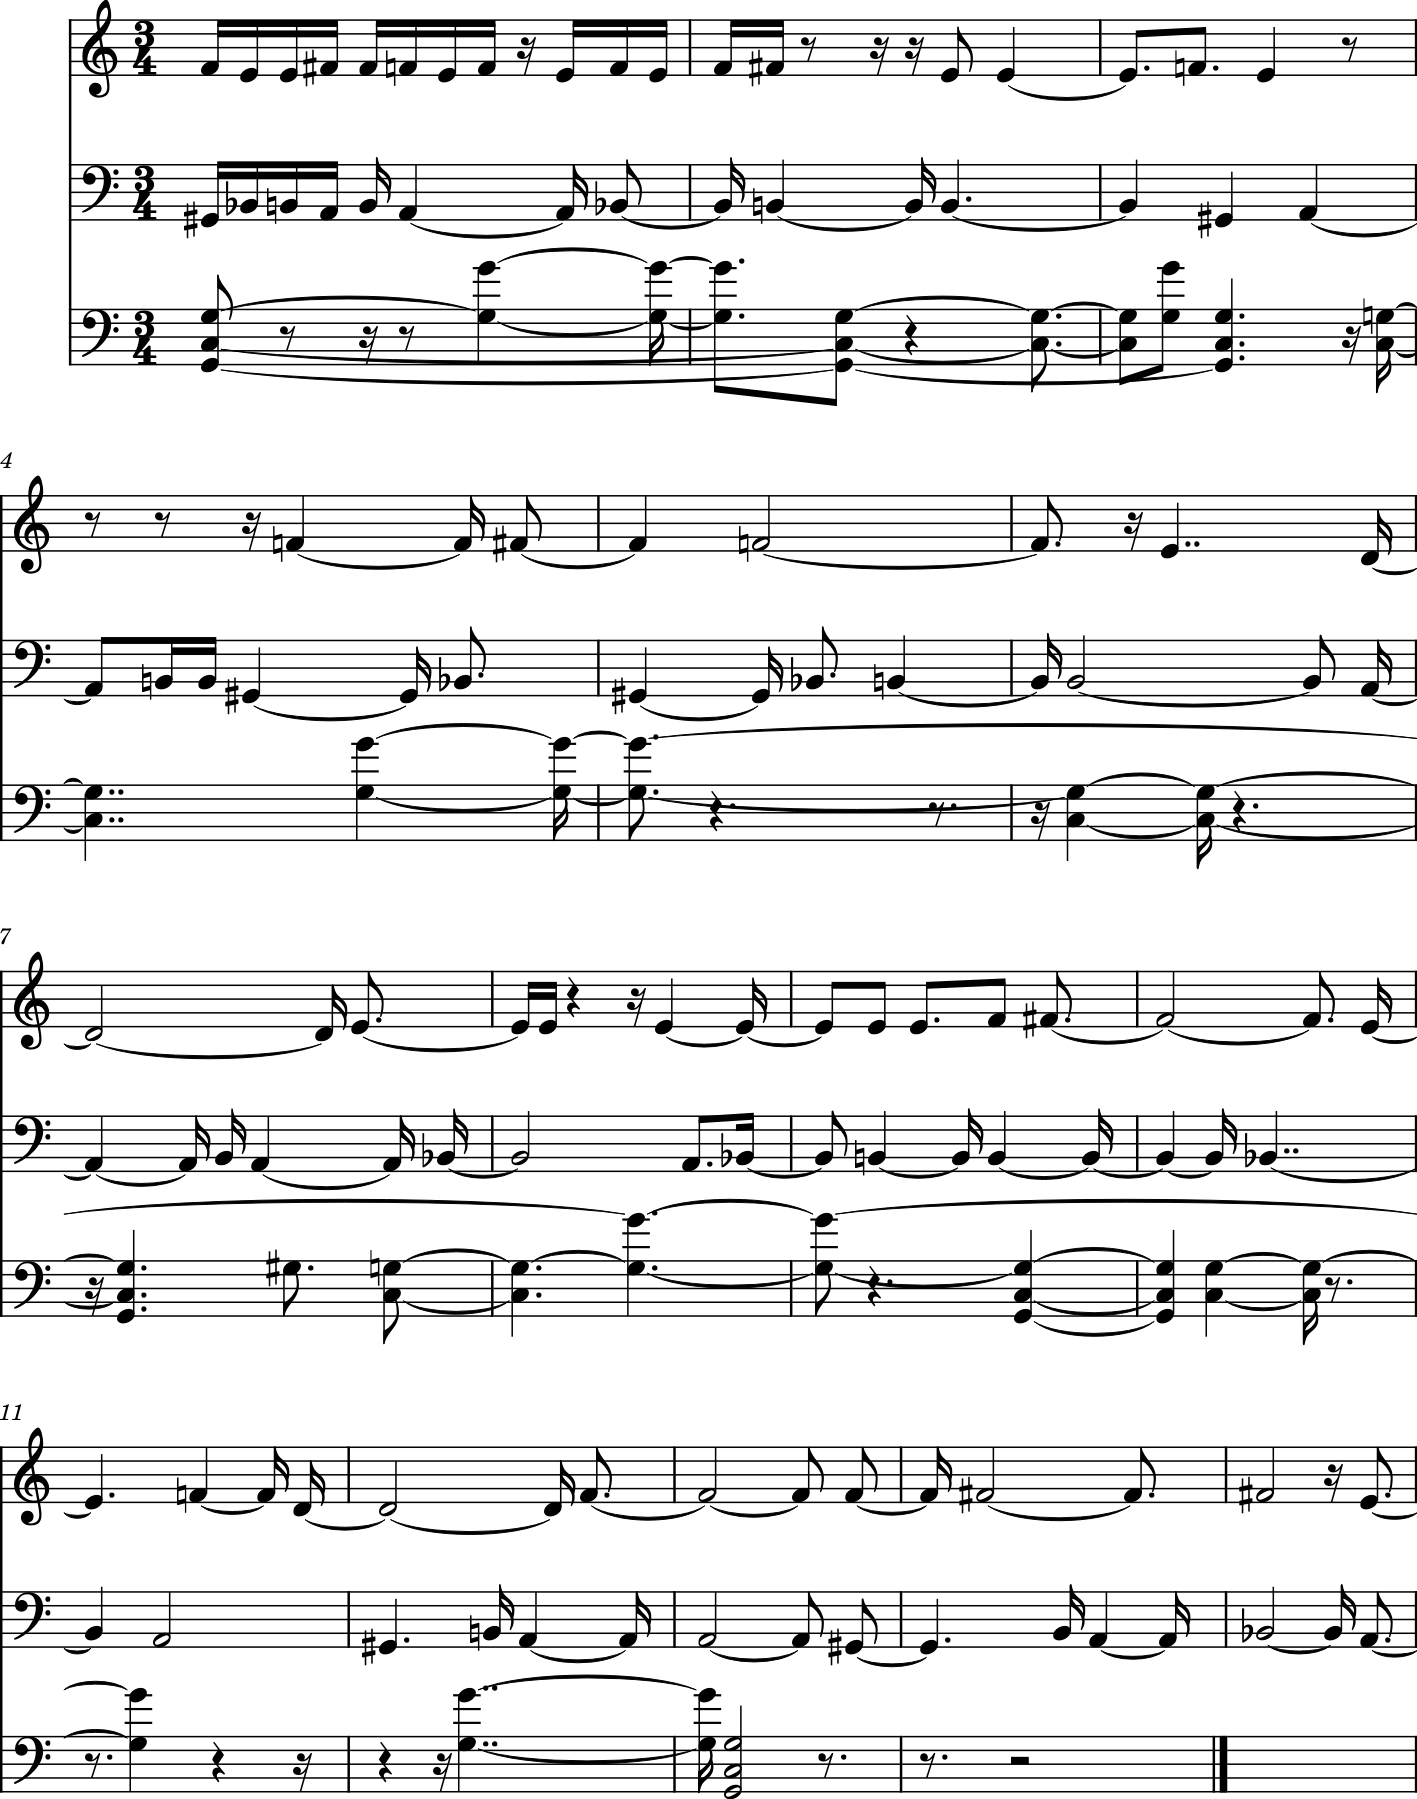

In [29]:
new_stream1 = transition_to_chaos(s1)
new_stream1.show()

In [30]:
play(new_stream1)

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
